## OVERVIEW OF OSEMiN

<img src='https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/images/OSEMN.png' width=800>

<center><a href="https://www.kdnuggets.com/2018/02/data-science-command-line-book-exploring-data.html"> 
    </a></center>


> <font size=2em>The Data Science Process we'll be using during this section--OSEMiN (pronounced "OH-sum", rhymes with "possum").  This is the most straightforward of the Data Science Processes discussed so far.  **Note that during this process, just like the others, the stages often blur together.***  It is completely acceptable (and ***often a best practice!) to float back and forth** between stages as you learn new things about your problem, dataset, requirements, etc.  
It's quite common to get to the modeling step and realize that you need to scrub your data a bit more or engineer a different feature and jump back to the "Scrub" stage, or go all the way back to the "Obtain" stage when you realize your current data isn't sufficient to solve this problem. 
As with any of these frameworks, *OSEMiN is meant to be treated as guidelines, not law. 
</font>


### OSEMN DETAILS

**OBTAIN**

- This step involves understanding stakeholder requirements, gathering information on the problem, and finally sourcing data that we think will be necessary for solving this problem. 

**SCRUB**

- During this stage, we'll focus on preprocessing our data.  Important steps such as identifying and removing null values, dealing with outliers, normalizing data, and feature engineering/feature selection are handled around this stage.  The line with this stage really blurs with the _Explore_ stage, as it is common to only realize that certain columns require cleaning or preprocessing as a result of the visualzations and explorations done during Step 3.  

- Note that although technically, categorical data should be one-hot encoded during this step, in practice, it's usually done after data exploration.  This is because it is much less time-consuming to visualize and explore a few columns containing categorical data than it is to explore many different dummy columns that have been one-hot encoded. 

**EXPLORE**

- This step focuses on getting to know the dataset you're working with. As mentioned above, this step tends to blend with the _Scrub_ step mentioned above.  During this step, you'll create visualizations to really get a feel for your dataset.  You'll focus on things such as understanding the distribution of different columns, checking for multicollinearity, and other tasks liek that.  If your project is a classification task, you may check the balance of the different classes in your dataset.  If your problem is a regression task, you may check that the dataset meets the assumptions necessary for a regression task.  

- At the end of this step, you should have a dataset ready for modeling that you've thoroughly explored and are extremely familiar with.  

**MODEL**

- This step, as with the last two frameworks, is also pretty self-explanatory. It consists of building and tuning models using all the tools you have in your data science toolbox.  In practice, this often means defining a threshold for success, selecting machine learning algorithms to test on the project, and tuning the ones that show promise to try and increase your results.  As with the other stages, it is both common and accepted to realize something, jump back to a previous stage like _Scrub_ or _Explore_, and make some changes to see how it affects the model.  

**iNTERPRET**

- During this step, you'll interpret the results of your model(s), and communicate results to stakeholders.  As with the other frameworks, communication is incredibily important! During this stage, you may come to realize that further investigation is needed, or more data.  That's totally fine--figure out what's needed, go get it, and start the process over! If your results are satisfactory to all stakeholders involved, you may also go from this stage right into productionizing your model and automating processes necessary to support it.  





## PROCESS CHECKLIST


> Keep in mind that it is normal to jump between the OSEMN phases and some of them will blend together, like SCRUB and EXPLORE.

1. **[OBTAIN](#OBTAIN)**
    - Import data, inspect, check for datatypes to convert and null values
    - Display header and info.
    - Drop any unneeded columns, if known (`df.drop(['col1','col2'],axis=1,inplace=True`)
    <br><br>


2. **[SCRUB](#SCRUB)**
    - Recast data types, identify outliers, check for multicollinearity, normalize data**
    - Check and cast data types
        - [ ] Check for #'s that are store as objects (`df.info()`,`df.describe()`)
            - when converting to #'s, look for odd values (like many 0's), or strings that can't be converted.
            - Decide how to deal weird/null values (`df.unique()`, `df.isna().sum()`)
            - `df.fillna(subset=['col_with_nulls'],'fill_value')`, `df.replace()`
        - [ ] Check for categorical variables stored as integers.
            - May be easier to tell when you make a scatter plotm or `pd.plotting.scatter_matrix()`
            
    - [ ] Check for missing values  (df.isna().sum())
        - Can drop rows or colums
        - For missing numeric data with median or bin/convert to categorical
        - For missing categorical data: make NaN own category OR replace with most common category
    - [ ] Check for multicollinearity
        - Use seaborn to make correlation matrix plot 
        - Good rule of thumb is anything over 0.75 corr is high, remove the variable that has the most correl with the largest # of variables
    - [ ] Normalize data (may want to do after some exploring)
        - Most popular is Z-scoring (but won't fix skew) 
        - Can log-transform to fix skewed data
    
    
3. **[EXPLORE](#EXPLORE)**
    - [ ] Check distributions, outliers, etc**
    - [ ] Check scales, ranges (df.describe())
    - [ ] Check histograms to get an idea of distributions (df.hist()) and data transformations to perform.
        - Can also do kernel density estimates
    - [ ] Use scatter plots to check for linearity and possible categorical variables (`df.plot("x","y")`)
        - categoricals will look like vertical lines
    - [ ] Use `pd.plotting.scatter_matrix(df)` to visualize possible relationships
    - [ ] Check for linearity.
   
   
4. **[MODEL](#MODEL)**

    - **Fit an initial model:** 
        - Run an initial model and get results

    - **Holdout validation / Train/test split**
        - use sklearn `train_test_split`
    
    
5. **[iNTERPRET](#iNTERPRET)**
    - **Assessing the model:**
        - Assess parameters (slope,intercept)
        - Check if the model explains the variation in the data (RMSE, F, R_square)
        - *Are the coeffs, slopes, intercepts in appropriate units?*
        - *Whats the impact of collinearity? Can we ignore?*
        <br><br>
    - **Revise the fitted model**
        - Multicollinearity is big issue for lin regression and cannot fully remove it
        - Use the predictive ability of model to test it (like R2 and RMSE)
        - Check for missed non-linearity
        
       
6. **Interpret final model and draw >=3 conclusions and recommendations from dataset**

<div style="display:block;border-bottom:solid red 3px;padding:1.4em;color:red;font-size:30pt;display:inline-block;line-height:1.5em;">
DELETE THIS CELL AND EVERYTHING ABOVE FROM YOUR FINAL NOTEBOOK
</div>

# Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time:
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION


## Business Problem

COVID-19 vaccines became available to subsets of the American public at the end of 2020. States and cities differed in terms of which groups of people were eligible first, and the timeline by which they expanded eligibility, but [by April 19th](https://www.nytimes.com/2021/04/19/world/adults-eligible-covid-vaccine.html), all Americans over the age of 16 were eligible.

Appointment availability was initially scarce in some places, but this very quickly shifted to a growing number of appointments going unfilled across the country. [Only 59% of adults have received at least one dose](https://covid.cdc.gov/covid-data-tracker/#datatracker-home) (as of this writing, on May 14th, 2021), so there are still plenty of people who haven't received any doses.

Vaccination rate is an important metric being considered as state and local governments decide how and when to relax mask-wearing, occupancy, and other COVID restrictions. These entities are already wondering about the best methods to encourage their populations to get vaccinated. In order to develop effective strategies, state and local governments need to understand the factors that contribute to vaccine hesitancy. 

To aid in this understanding, I will build a predictive model to classify whether someone is likely to be vaccine optimistic, or vaccine hesitant, based on their other answers to the Household Pulse Survey that the US Census has been conducting bi-weekly during the pandemic. Interpreting the factors which are most important in predicting vaccine hesitancy among populations should provide insights that will allow state and local governments to develop effective outreach strategies.




# OBTAIN

## Data Understanding

For this analysis, I will use a [publicly available microdata sample](https://www.census.gov/programs-surveys/household-pulse-survey/datasets.html) from the bi-weekly Household Pulse Surveys that the US Census has been conducting during the pandemic. Each observation represents an individual's anonymized response to the survey.

Respondents were randomly sampled from all 50 states and the top 15 metropolitan areas, and asked to fill out the survey online. They were asked a variety of questions about their household, including whether they've received any doses of the vaccine, and if not, what their intent was to do so in the future. I will engineer these features into a binary target variable representing vaccine optimism versus vaccine hesitancy, and use each respondent's answers to other survey questions as the predictors.

Some survey questions were only presented to the respondent if they answered a certain way to a prior question, such as only asking about intention to get a vaccine in the future if the respondent indicated they had not yet received any doses. I will carefully review the data dictionary provided by the Census team to understand these relationships, and  engineer features from the groups of questions as appropriate.

I will use the most recent microdata file available as of this writing, May 14, 2021, which includes a sample of about 78,000 responses from Phase 3 of the survey, covering the timeframe of March 3 to March 15, 2021. This is referred to as the "week 26" period.  Note that the survey is ongoing and currently in Phase 3.1, but microdata is not yet available for the first week of Phase 3.1, so I will use the most recent data available.

For more technical information on the sampling methodology and full questionnaire, [see here](https://www.census.gov/programs-surveys/household-pulse-survey/technical-documentation.html).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import plotly.express as px

pd.set_option('display.max_info_rows', 300)
pd.set_option('display.max_info_columns', 300)

In [2]:
# import data from downloaded CSV
df = pd.read_csv(r"data/pulse2021_puf_26.csv.tar.gz")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78307 entries, 0 to 78306
Data columns (total 204 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   ._pulse2021_puf_26.csv  object 
 1   WEEK                    float64
 2   EST_ST                  float64
 3   EST_MSA                 float64
 4   REGION                  float64
 5   HWEIGHT                 float64
 6   PWEIGHT                 float64
 7   TBIRTH_YEAR             float64
 8   ABIRTH_YEAR             float64
 9   EGENDER                 float64
 10  AGENDER                 float64
 11  RHISPANIC               float64
 12  AHISPANIC               float64
 13  RRACE                   float64
 14  ARACE                   float64
 15  EEDUC                   float64
 16  AEDUC                   float64
 17  MS                      float64
 18  THHLD_NUMPER            float64
 19  AHHLD_NUMPER            float64
 20  THHLD_NUMKID            float64
 21  AHHLD_NUMKID            float64
 2

I will primarily use the data dictionary provided by the Census team to determine which fields to include in my initial model.

Although all the data fields are stored as floats, based on the dictionary most of them are actually ordinally encoded categorical variables. I will need to combine them or convert them to text categories as appropriate.

# SCRUB

I will need to engineer multiple features, including my target. As written and organized into a question per column, the data is not in ideal format for analysis due to the presence of main question and sub-question groups; some questions are conceptually spread across multiple columns.

I will endeavor to balance reducing the feature space with keeping as much of the original information as possible.

One notable challenge will be dealing with missing data. The data dictionary indicates that there are two placeholders that represent a non-answer: 
- -88: Missing / Did not report
- -99: Question seen but category not selected

The Census team provides no additional information about why a response might be missing and placed in the -88 category as opposed to the -99 category that represents a lack of a response from the respondent. I have reached out to them via email for explanation, but have not yet heard back. Although some instances appear to be filled in to account for the fact that a sub-question wasn't presented to a respondent because of how they answered a prior question, there are some columns with -88 placeholders that do not appear to be sub-questions, so in my understanding should have been presented to everyone. 

Since there are a significant number of these -88 placeholders in some top-level question columns, I will likely encode them as a separate category instead of dropping them or attempting to impute them.

## Target columns

I want to create a binary target that represents a respondent's vaccine outlook: hesitant, or optimistic.

I will need to engineer this target from two questions: 
- `RECVDVACC` asked the respondent whether they have received any doses of the COVID vaccine
- `GETVACC` is a sub-question asked of the respondent if they said they had not received any doses. It asked about the respondent's intent to get a vaccine in the future. Choices include:

1. Definitely get a vaccine
2. Probably get a vaccine
3. Probably NOT get a vaccine 
4. Definitely NOT get a vaccine

At the time of the survey back in early March, only certain subsets of the population were eligible to make a vaccine appointment, based on state-specific criteria such as age, occupation, health risk indicators, and other factors. I want to make sure my class takes into account people who have been vaccinated but doesn't penalize people who have not yet been vaccinated yet, given there is no easy way to know if they were eligible for vaccination when they were surveyed. 

I will create the binary target by combining answers to these two questions in the following way:

**Vaccine optimistic**
- Has received at least one dose OR
- Has not received any doses yet AND:
    - Intends to Definitely get a vaccine OR
    - Intends to Probably get a vaccine

**Vaccine hesitant**
- Has not received any doses yet AND:
    - Intends to Probably NOT get a vaccine OR
    - Intends to Definitely NOT get a vaccine


In [3]:
# First question asking whether they have received any doses
df['RECVDVACC'].value_counts()

 2.0     42085
 1.0     35840
-99.0      381
Name: RECVDVACC, dtype: int64

In [4]:
df['RECVDVACC'].isna().sum()

1

In [5]:
df.loc[df['RECVDVACC'].isna()]

,._pulse2021_puf_26.csv,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,EGENDER,...,PSWHYCHG1,PSWHYCHG2,PSWHYCHG3,PSWHYCHG4,PSWHYCHG5,PSWHYCHG6,PSWHYCHG7,PSWHYCHG8,PSWHYCHG9,INCOME
78306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Value of 1 indicates Yes, at least one dose
- Value of 2 indicates No, no doses yet
- Value of -99 indicates the respondent did not answer the question

I will drop the -99 values, since there are few of them and I wouldn't be comfortable imputing target variables.

In [6]:
to_drop = df.loc[df['RECVDVACC'] == -99.0].index
df.drop(index=to_drop, inplace=True)

df['RECVDVACC'].value_counts()

2.0    42085
1.0    35840
Name: RECVDVACC, dtype: int64

It looks like there was an extra blank line at the end of the file that is NaN for all values, so I'll remove that too.

In [7]:
df.dropna(axis=0, how='all', inplace=True)

In [8]:
df['GETVACC'].value_counts()

-88.0    35840
 1.0     24576
 2.0      7904
 3.0      5271
 4.0      4234
-99.0      100
Name: GETVACC, dtype: int64

In [9]:
df['GETVACC'].isna().sum()

0

This question was only asked of respondents who said they had not received any doses yet.

- Value of 1 indicates will Definitely get a vaccine
- Value of 2 indicates will Probably get a vaccine
- Value of 3 indicates will Probably NOT get a vaccine 
- Value of 4 indicates will Definitely NOT get a vaccine
- Value of -99 indicates the respondent did not answer the question

A value of -88 is described as simply missing in the data dictionary. In this case, we know that this question was asked of a subset of people who sad they hadn't received any doses, and the count of value -88 in this question matches the count of 1 - Yes in the previous question.

I will confirm that these -88 placeholders represent people who received a dose of the vaccine.

In [10]:
# Do 'GETVACC' values of -88 also have 'RECVDVACC' values of 1?
df.loc[df['GETVACC'] == -88.0]['RECVDVACC'].value_counts()

1.0    35840
Name: RECVDVACC, dtype: int64

Yes, all the -88 values from the second question are people who answered Yes (1.0) in the first question.

I will drop the -99 values to the second question since they are also very small in size. Then I will create a binary target based on the logic outlined in the header section above.

In [11]:
# drop -99 values, where the respondent didn't answer the question
to_drop = df.loc[df['GETVACC'] == -99.0].index
df.drop(index=to_drop, inplace=True)

# Target class 0 will be vaccine optimistic
df.loc[(df['RECVDVACC'] == 1.0) | 
       (df['GETVACC'] == 1.0) | 
       (df['GETVACC'] == 2.0), 'target'] = 0

# Target class 1 will be vaccine hesitant
df.loc[(df['GETVACC'] == 3.0) | 
       (df['GETVACC'] == 4.0), 'target'] = 1

df['target'].value_counts()

0.0    68320
1.0     9505
Name: target, dtype: int64

In [12]:
df['target'].value_counts(normalize=True)

0.0    0.877867
1.0    0.122133
Name: target, dtype: float64

In [13]:
df['target'].isna().sum()

0

## Predictor Columns

I used the data dictionary provided by the Census as the primary method of determining which columns were categorical versus numeric, and which I wanted to use versus leave out of the initial exploration. A copy of the data dictionary is provided in the data folder.

Many of the questions asked in this survey involve potentially sensitive topics, such as race, financial circumstances, participation level in social assistance programs, household spending habits, aspects of mental health, etc. I will therefore do my utmost to apply consistent, objective criteria regarding which columns to include or remove in the model to avoid unintentional personal bias, and will provide detail regarding each of these tactical decisions.

### Initial Columns to Exclude

As a first pass, I identified the following characteristics of columns in the data set that led me to decide to exclude them in the initial exploration and likely from the model.

#### Subquestions

Certain questions were asked of respondents only if they answered in a certain way to a prior question. One example would be the set of `WHYCHNGD` subquestions asking WHY household spending had changed, which were only presented to respondents who said their household spending HAD changed.

I think these subquestions will be very useful in understanding more nuance about the opinions and circumstances of households, if the primary question turns out to be an important predictor of vaccine hesitancy. However, I will include only the top-level questions in the modeling process.

Fields that represent subquestions (based on the data dictionary), and will be excluded from initial analysis are:

- WHYNOT1
- WHYNOT2
- WHYNOT3
- WHYNOT4
- WHYNOT5
- WHYNOT6
- WHYNOT7
- WHYNOT8
- WHYNOT9
- WHYNOT10
- WHYNOT11
- WHYNOTB1
- WHYNOTB2
- WHYNOTB3
- WHYNOTB4
- WHYNOTB5
- WHYNOTB6
- RSNNOWRK
- SSAPGM1
- SSAPGM2
- SSAPGM3
- SSAPGM4
- SSAPGM5
- SSALIKELY
- SSAEXPCT1
- SSAEXPCT2
- SSAEXPCT3
- SSAEXPCT4
- SSAEXPCT5
- SSADECISN
- EIPSPND1
- EIPSPND2
- EIPSPND3
- EIPSPND4
- EIPSPND5
- EIPSPND6
- EIPSPND7
- EIPSPND8
- EIPSPND9
- EIPSPND10
- EIPSPND11
- EIPSPND12
- EIPSPND13
- WHYCHNGD1
- WHYCHNGD2
- WHYCHNGD3
- WHYCHNGD4
- WHYCHNGD5
- WHYCHNGD6
- WHYCHNGD7
- WHYCHNGD8
- WHYCHNGD9
- WHYCHNGD10
- WHYCHNGD11
- WHYCHNGD12
- WHYCHNGD13
- CHILDFOOD
- FOODSUFRSN1
- FOODSUFRSN2
- FOODSUFRSN3
- FOODSUFRSN4
- FOODSUFRSN5
- WHEREFREE1
- WHEREFREE2
- WHEREFREE3
- WHEREFREE4
- WHEREFREE5
- WHEREFREE6
- WHEREFREE7
- RENTCUR
- MORTCUR
- MORTCONF
- EVICT
- FORCLOSE
- TEACH1
- TEACH2
- TEACH3
- TEACH4
- TEACH5
- COMPAVAIL
- COMP1
- COMP2
- COMP3
- INTRNTAVAIL
- INTRNT1
- INTRNT2
- INTRNT3
- KINDWORK
- SCHLHRS
- TSTDY_HRS
- TCH_HRS
- PSPLANS1
- PSPLANS2
- PSPLANS3
- PSPLANS4
- PSPLANS5
- PSPLANS6
- PSCHNG1
- PSCHNG2
- PSCHNG3
- PSCHNG4
- PSCHNG5
- PSCHNG6
- PSCHNG7
- PSWHYCHG1
- PSWHYCHG2
- PSWHYCHG3
- PSWHYCHG4
- PSWHYCHG5
- PSWHYCHG6
- PSWHYCHG7
- PSWHYCHG8
- PSWHYCHG9
- DOSES

#### Duplicates, Metadata, and Imputed values

Several columns were already imputed into appropriate summary columns by the Census team, which means the original columns are essentially duplicates:

- THHLD_NUMPER
- HLTHINS1
- HLTHINS2
- HLTHINS3
- HLTHINS4
- HLTHINS5
- HLTHINS6
- HLTHINS7
- HLTHINS8

The REGION column will also not be included, as the dataset contains other columns that can be used to represent geographical characteristics.

A few columns represent metadata such as household identifier, and weight calculations to be used to generate population statistics:

- SCRAM
- PWEIGHT
- HWEIGHT
- WEEK

The following columns are indicators that a value was imputed by the Census team:

- ABIRTH_YEAR
- AGENDER
- AHISPANIC
- ARACE
- AEDUC
- AHHLD_NUMPER
- AHHLD_NUMKID

### Categories to Engineer

Some categorical columns can be combined fairly easily into a single columns without losing information. I will combine them to simplify and reduce the feature space.

In [14]:
# Combine HLTHINS multi-choice answers to represent has insurance or not

# Assign 1 if any health insurance option chosen
df.loc[(df['HLTHINS1']==1)|(df['HLTHINS2']==1)|(df['HLTHINS3']==1)|
       (df['HLTHINS4']==1)|(df['HLTHINS5']==1)|(df['HLTHINS6']==1)|
       (df['HLTHINS7']==1)|(df['HLTHINS8']==1), ['HLTHINS']] = 1

# Assign 0 if No seleted for all
df.loc[(df['HLTHINS1']==2)&(df['HLTHINS2']==2)&(df['HLTHINS3']==2)&
       (df['HLTHINS4']==2)&(df['HLTHINS5']==2)&(df['HLTHINS6']==2)&
       (df['HLTHINS7']==2)&(df['HLTHINS8']==2), ['HLTHINS']] = 0

# Assign 0 if didn't answer
df.loc[df['HLTHINS'].isna(), ['HLTHINS']] = 0

df['HLTHINS'].value_counts()

1.0    61184
0.0    16641
Name: HLTHINS, dtype: int64

In [15]:
# Create a single categorical column for children enrolled in school outside
# the home

# Assign 1 if have any children enrolled in school outside the home
df.loc[(df['ENROLL1']==1), ['SCHOOL_KIDS']] = 1

# Assign 0 if have ONLY children who are being homeschooled
df.loc[(df['ENROLL2']==1) & (df['SCHOOL_KIDS'].isna()), ['SCHOOL_KIDS']] = 0

# Assign 3 if indicated did NOT have children enrolled in school
df.loc[(df['ENROLL3']==1) & (df['SCHOOL_KIDS'].isna()), ['SCHOOL_KIDS']] = 0

# Assign 0 if did not answer; assume this means they don't have kids of
# school age
df.loc[df['SCHOOL_KIDS'].isna(), ['SCHOOL_KIDS']] = 0

df['SCHOOL_KIDS'].value_counts()

0.0    63559
1.0    14266
Name: SCHOOL_KIDS, dtype: int64

In [16]:
# Combine TSPNDPRPD and TSPNDFOOD into a single column representing the
# proportion of money spent on food that was on food to be eaten at home
# TSPNDPRPD is amount spent on prepared meals
# TSPNDFOOD is amount spent on food to be prepared at home

# if respondent entered one food amount but not the other, assume they left
# the other blank because it should be 0
df.loc[(df['TSPNDPRPD'] < 0) & (df['TSPNDFOOD'] >0), 'TSPNDPRPD'] = 0
df.loc[(df['TSPNDPRPD'] > 0) & (df['TSPNDFOOD'] <0), 'TSPNDFOOD'] = 0

# Only calculate if respondent included an answer for one
ans = df.loc[(df['TSPNDPRPD'] >0) | (df['TSPNDFOOD'] >0), ['TSPNDPRPD', 'TSPNDFOOD']]
ans.head()

,TSPNDPRPD,TSPNDFOOD
1,50.0,200.0
3,0.0,300.0
4,210.0,100.0
5,200.0,200.0
6,0.0,40.0


In [17]:
# Populate proportion of food spend that was on food to be prepared
# at home
ans['PROP_FOODSPEND_HOME'] = ans.apply(lambda x: x[1]/np.sum(x), axis=1)
ans.head()

,TSPNDPRPD,TSPNDFOOD,PROP_FOODSPEND_HOME
1,50.0,200.0,0.800000
3,0.0,300.0,1.000000
4,210.0,100.0,0.322581
5,200.0,200.0,0.500000
6,0.0,40.0,1.000000


In [18]:
# merge results back into main df
df = df.merge(right=ans['PROP_FOODSPEND_HOME'], how='left', 
         left_on=df.index, right_on=ans.index)

df[['TSPNDPRPD','TSPNDFOOD','PROP_FOODSPEND_HOME']].head(20)

,TSPNDPRPD,TSPNDFOOD,PROP_FOODSPEND_HOME
0,-88.0,-88.0,NaN
1,50.0,200.0,0.800000
2,-88.0,-88.0,NaN
3,0.0,300.0,1.000000
4,210.0,100.0,0.322581
5,200.0,200.0,0.500000
6,0.0,40.0,1.000000
7,0.0,800.0,1.000000
8,8.0,84.0,0.913043
9,25.0,120.0,0.827586


In [19]:
# Insert appropriate -99 and -88 values, so can assess -88s in bulk
# with other columns later
df.loc[(df['TSPNDPRPD'] ==-88) & (df['TSPNDFOOD'] ==-88), 'PROP_FOODSPEND_HOME'] = -88
df.loc[(df['TSPNDPRPD'] ==-99) & (df['TSPNDFOOD'] ==-99), 'PROP_FOODSPEND_HOME'] = -99

In [20]:
df.loc[df['PROP_FOODSPEND_HOME'].isna(), ['TSPNDPRPD','TSPNDFOOD','PROP_FOODSPEND_HOME']]

,TSPNDPRPD,TSPNDFOOD,PROP_FOODSPEND_HOME
64,0.0,0.0,NaN
191,0.0,-99.0,NaN
284,0.0,0.0,NaN
287,0.0,0.0,NaN
388,-88.0,-99.0,NaN
...,...,...,...
77416,0.0,0.0,NaN
77439,-88.0,-99.0,NaN
77656,-88.0,-99.0,NaN
77680,0.0,-99.0,NaN


In [21]:
# For the ones where people put 0 for both, going to fill in with 0
df.loc[(df['TSPNDPRPD'] ==0) & (df['TSPNDFOOD'] ==0) & 
       (df['PROP_FOODSPEND_HOME'].isna()), 'PROP_FOODSPEND_HOME'] = 0

# For the rest of the nas, put -99
df.loc[df['PROP_FOODSPEND_HOME'].isna(), 'PROP_FOODSPEND_HOME'] = -99

df.loc[df['PROP_FOODSPEND_HOME'].isna(), ['TSPNDPRPD','TSPNDFOOD','PROP_FOODSPEND_HOME']]

,TSPNDPRPD,TSPNDFOOD,PROP_FOODSPEND_HOME


In [22]:
df['PROP_FOODSPEND_HOME'].describe()

count    77825.000000
mean       -15.693697
std         35.134390
min        -99.000000
25%          0.462366
50%          0.714286
75%          0.877193
max          1.000000
Name: PROP_FOODSPEND_HOME, dtype: float64

In [23]:
# Create column to represent whether household was in a metropolitan statistical
# area or not

df.loc[df['EST_MSA'] > 0, 'IN_METRO_AREA'] = 1
df.loc[df['IN_METRO_AREA'].isna(), 'IN_METRO_AREA'] = 0

df['IN_METRO_AREA'].value_counts()

0.0    51865
1.0    25960
Name: IN_METRO_AREA, dtype: int64

In [24]:
# convert -99 values to 0 in columns that represent checkboxes that are
# part of a larger multiple choice question
# This essentially OHE's them, except there are some values with -88
# which appear to be mising across the board

multichoice_cols = ['SPNDSRC1','SPNDSRC2','SPNDSRC3','SPNDSRC4','SPNDSRC5',
                    'SPNDSRC6','SPNDSRC7','SPNDSRC8','CHNGHOW1','CHNGHOW2',
                    'CHNGHOW3','CHNGHOW4','CHNGHOW5','CHNGHOW6','CHNGHOW7',
                    'CHNGHOW8','CHNGHOW9','CHNGHOW10','CHNGHOW11','CHNGHOW12']

for col in multichoice_cols:
    df.loc[df[col] == -99, col] = 0
    
df[multichoice_cols].head(20)

,SPNDSRC1,SPNDSRC2,SPNDSRC3,SPNDSRC4,SPNDSRC5,SPNDSRC6,SPNDSRC7,SPNDSRC8,CHNGHOW1,CHNGHOW2,CHNGHOW3,CHNGHOW4,CHNGHOW5,CHNGHOW6,CHNGHOW7,CHNGHOW8,CHNGHOW9,CHNGHOW10,CHNGHOW11,CHNGHOW12
0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
# Convert birth year to age
df['AGE'] = df['TBIRTH_YEAR'].map(lambda x: 2021-x)

df['AGE'].describe()

count    77825.000000
mean        54.562159
std         15.898557
min         18.000000
25%         42.000000
50%         56.000000
75%         67.000000
max         88.000000
Name: AGE, dtype: float64

In [26]:
df['AGE'].isna().sum()

0

In [27]:
# Running list of the categorical and numeric column names, both engineered
# and original

cat_cols = ['HLTHINS', 'SCHOOL_KIDS', 'IN_METRO_AREA', 'ANXIOUS','ANYWORK',
            'CHNGHOW1','CHNGHOW10','CHNGHOW11','CHNGHOW12','CHNGHOW2',
            'CHNGHOW3','CHNGHOW4','CHNGHOW5','CHNGHOW6','CHNGHOW7','CHNGHOW8',
            'CHNGHOW9','CURFOODSUF','DELAY','DOWN','EEDUC','EGENDER','EIP',
            'EXPCTLOSS','EXPNS_DIF','FEWRTRANS','FEWRTRIPS','FREEFOOD',
            'HADCOVID','INCOME','INTEREST','LIVQTR','MH_NOTGET','MH_SVCS',
            'MS','NOTGET','PLNDTRIPS','PRESCRIPT','RHISPANIC','RRACE',
            'SNAP_YN','SPNDSRC1','SPNDSRC2','SPNDSRC3','SPNDSRC4','SPNDSRC5',
            'SPNDSRC6','SPNDSRC7','SPNDSRC8','SSA_APPLY','SSA_RECV','TENURE',
            'TW_START','UI_APPLY','UI_RECV','WORRY','WRKLOSS']

cat_cols.sort()

num_cols = ['PROP_FOODSPEND_HOME', 'AGE', 'THHLD_NUMADLT','THHLD_NUMKID',
            'TNUM_PS']



In [28]:
for col in cat_cols:
    print(df[col].value_counts())

 1.0     27320
 2.0     20314
-88.0    12614
 4.0     10040
 3.0      7173
-99.0      364
Name: ANXIOUS, dtype: int64
 1.0     44266
 2.0     33312
-99.0      247
Name: ANYWORK, dtype: int64
 0.0     38740
 1.0     34878
-88.0     4207
Name: CHNGHOW1, dtype: int64
 0.0     68799
 1.0      4819
-88.0     4207
Name: CHNGHOW10, dtype: int64
 0.0     72049
-88.0     4207
 1.0      1569
Name: CHNGHOW11, dtype: int64
 0.0     54509
 1.0     19109
-88.0     4207
Name: CHNGHOW12, dtype: int64
 0.0     56443
 1.0     17175
-88.0     4207
Name: CHNGHOW2, dtype: int64
 0.0     67959
 1.0      5659
-88.0     4207
Name: CHNGHOW3, dtype: int64
 0.0     51444
 1.0     22174
-88.0     4207
Name: CHNGHOW4, dtype: int64
 0.0     71127
-88.0     4207
 1.0      2491
Name: CHNGHOW5, dtype: int64
 0.0     36929
 1.0     36689
-88.0     4207
Name: CHNGHOW6, dtype: int64
 0.0     67489
 1.0      6129
-88.0     4207
Name: CHNGHOW7, dtype: int64
 0.0     58778
 1.0     14840
-88.0     4207
Name: CHNGHOW8, dtype

In [29]:
for col in num_cols:
    print(df[col].isna().sum())
    print(df[col].describe())

0
count    77825.000000
mean       -15.693697
std         35.134390
min        -99.000000
25%          0.462366
50%          0.714286
75%          0.877193
max          1.000000
Name: PROP_FOODSPEND_HOME, dtype: float64
0
count    77825.000000
mean        54.562159
std         15.898557
min         18.000000
25%         42.000000
50%         56.000000
75%         67.000000
max         88.000000
Name: AGE, dtype: float64
0
count    77825.000000
mean         2.122981
std          0.966851
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         10.000000
Name: THHLD_NUMADLT, dtype: float64
0
count    77825.000000
mean         0.588024
std          1.010032
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: THHLD_NUMKID, dtype: float64
0
count    77825.000000
mean       -19.387189
std         37.068353
min        -99.000000
25%          0.000000
50%          0.000000
75%          0.

Of the columns I initially had listed as categorical, I used the value counts above, combined with reviewing the meanings of each label in the data dictionary, to make further decisions on each column.

- Many of these columns are almost already OHE. There are already only 2 choices, mostly Yes/No answers, but a few others such as gender Male/Female. 
    - Many of the Yes/No questions actually have Yes encoded as 1 and No encoded as 2, so I'm going to mass replace those with 0 instead of 2 to be more consistent with how OHE typically works.
    - A few can be turned into OHE columns if I combine rare labels.


- A few categorical columns are suited to be left as ordinals and treated like numbers. These columns are:
    - `ANXIOUS`, `DOWN`, `INTEREST` (lack of), and `WORRY`: as value increases, frequency of experiencing these feelings increases.
    - `CURFOODSUF`: as value increases, food insecurity increases / food suffiency decreases.
    - `EEDUC`: as value increases, education level represented by years of schooling required to obtain that level increases.
    - `EXPNS_DIF`: as value increases, difficulty with expenses increases
    - `INCOME`: as value increases, pre-tax income range increases
    
    
- 6 categorical columns do need to be OHE because they have more than two choices that can't be combined without losing information.


- I will drop `UI_RECV` because the vast majority of its values are -88 missing, so it has little to contribute in terms of actual answers the respondents provided.

Almost all of the columns have -99 values that represent the respondent skipped the question, and -88 values that are simply missing with no explanation. Before accepting that I need to make 2 separate columns for every one of these (expanding my feature space by a lot) I'm going to map them using missingno and see if I can identify patterns. Maybe values that are -88 across multiple columns can be bundled together in fewer missing indicator columns.

Of the numerical columns, I will turn `TNUM_PS` into a Yes/No categorical column, since it appears most households have no one who was planning on post-secondary education in fall 2021. I don't think the number of people will make a big difference.

In [30]:
# for columns that really only have 2 answers, most are 1 and 2. Leave 1 as Yes
# and convert the 2s to 0s for Nos or second value.

conv_2_to_0 = ['ANYWORK', 'DELAY', 'EGENDER', 'EXPCTLOSS', 'FEWRTRIPS', 
               'FREEFOOD', 'HADCOVID', 'MH_NOTGET', 'MH_SVCS', 'NOTGET', 
               'PLNDTRIPS','PRESCRIPT', 'SNAP_YN', 'SSA_APPLY', 'SSA_RECV', 
               'UI_APPLY', 'WRKLOSS']

for col in conv_2_to_0:
    df.loc[df[col] == 2, col] = 0
    print(df[col].value_counts())

 1.0     44266
 0.0     33312
-99.0      247
Name: ANYWORK, dtype: int64
 0.0     46448
 1.0     17044
-88.0    13906
-99.0      427
Name: DELAY, dtype: int64
0.0    46326
1.0    31499
Name: EGENDER, dtype: int64
 0.0     66184
 1.0     11349
-99.0      292
Name: EXPCTLOSS, dtype: int64
 1.0     42247
 0.0     27499
-88.0     7438
-99.0      641
Name: FEWRTRIPS, dtype: int64
 0.0     64839
-88.0     8032
 1.0      4592
-99.0      362
Name: FREEFOOD, dtype: int64
 0.0     68660
 1.0      8527
 3.0       514
-99.0      124
Name: HADCOVID, dtype: int64
 0.0     56873
-88.0    13906
 1.0      6658
-99.0      388
Name: MH_NOTGET, dtype: int64
 0.0     56552
-88.0    13906
 1.0      6911
-99.0      456
Name: MH_SVCS, dtype: int64
 0.0     51332
-88.0    13906
 1.0     12182
-99.0      405
Name: NOTGET, dtype: int64
 1.0     55601
 0.0     14386
-88.0     7438
-99.0      400
Name: PLNDTRIPS, dtype: int64
 0.0     49248
 1.0     14233
-88.0    13906
-99.0      438
Name: PRESCRIPT, dtype: int64

In [31]:
# OHE HADCOVID by combining rare label 3 - Not Sure with -99 No Answer
df.loc[df['HADCOVID']==3, 'HADCOVID'] = -99
df['HADCOVID'].value_counts()

 0.0     68660
 1.0      8527
-99.0      638
Name: HADCOVID, dtype: int64

In [32]:
# Make RHISPANIC consistent with 0=No, 1=Yes
df.loc[df['RHISPANIC']==1, 'RHISPANIC'] = 0
df.loc[df['RHISPANIC']==2, 'RHISPANIC'] = 1
df['RHISPANIC'].value_counts()

0.0    70428
1.0     7397
Name: RHISPANIC, dtype: int64

In [33]:
# TW_Start labels 2 and 3 are both no telework, so converting to 0
df.loc[(df['TW_START']==2)|(df['TW_START']==3), 'TW_START'] = 0
df['TW_START'].value_counts()

 0.0     42009
 1.0     32097
-99.0     3719
Name: TW_START, dtype: int64

In [34]:
# LIVQTR will need to be OHE, but I can combine some labels and not lose
# much information

df['LIVQTR'].value_counts()

 2.0     44955
-88.0    14502
 3.0      4975
 9.0      2730
 1.0      1921
 6.0      1746
 5.0      1729
 7.0      1562
 8.0      1479
 4.0      1254
-99.0      698
 10.0      274
Name: LIVQTR, dtype: int64

Category labels from the data dictionary:
1. A mobile home
2. A one-family house detached from any other house
3. A one-family house attached to one or more houses
4. A building with 2 apartments
5. A building with 3 or 4 apartment
6. A building with 5 to 9 apartments
7. A building with 10 to 19 apartments
8. A building with 20 to 49 apartments 
9. A building with 50 or more apartments
10. Boat, RV, van, etc.

-99. Question seen but category not selected

-88. Missing / Did not report

I will combine these 10 categories into 3:
- 1 and 10: Mobile home, Boat, RV, van, etc.
- 2 and 3: House
- 4 through 9: Apartment


In [35]:
df.loc[df['LIVQTR']==10, 'LIVQTR'] = 1
df.loc[df['LIVQTR']==3, 'LIVQTR'] = 2
df.loc[df['LIVQTR'].isin([4,5,6,7,8,9]), 'LIVQTR'] = 3

In [36]:
df['LIVQTR'].value_counts()

 2.0     49930
-88.0    14502
 3.0     10500
 1.0      2195
-99.0      698
Name: LIVQTR, dtype: int64

In [37]:
# Combine a few rare Married Status labels
# Adding 3 - divorced and 4 - separated into 2 - Widowed (all sound single now
# but used to be married)
# 1 is married, and 5 is never married

df.loc[df['MS'].isin([3, 4]), 'MS'] = 2
df['MS'].value_counts()

 1.0     45740
 2.0     17835
 5.0     13762
-99.0      488
Name: MS, dtype: int64

In [38]:
# OHE TNUM_PS manually
df['TNUM_PS'].value_counts()

 0.0     45969
-88.0    15652
 1.0     10678
 2.0      3138
-99.0     1525
 3.0       863
Name: TNUM_PS, dtype: int64

In [39]:
# These represent the number of people in the household who plan to go to
# post-secondary classes in 2021. Since there aren't a lot of 2 and 3 values,
# will combine them into 1 so it's just a Yes have people who plan to take
# PS classes, or No have none in the household.
df.loc[df['TNUM_PS'].isin([2, 3]), 'TNUM_PS'] = 1
df['TNUM_PS'].value_counts()

 0.0     45969
-88.0    15652
 1.0     14679
-99.0     1525
Name: TNUM_PS, dtype: int64

In [40]:
# drop UI_RECV from cat_cols, as majority of values are -88 missing
df['UI_RECV'].value_counts(normalize=True)

-88.0    0.847941
 1.0     0.121825
 2.0     0.027857
-99.0    0.002377
Name: UI_RECV, dtype: float64

In [41]:
cat_cols.remove('UI_RECV')
cat_cols

['ANXIOUS',
 'ANYWORK',
 'CHNGHOW1',
 'CHNGHOW10',
 'CHNGHOW11',
 'CHNGHOW12',
 'CHNGHOW2',
 'CHNGHOW3',
 'CHNGHOW4',
 'CHNGHOW5',
 'CHNGHOW6',
 'CHNGHOW7',
 'CHNGHOW8',
 'CHNGHOW9',
 'CURFOODSUF',
 'DELAY',
 'DOWN',
 'EEDUC',
 'EGENDER',
 'EIP',
 'EXPCTLOSS',
 'EXPNS_DIF',
 'FEWRTRANS',
 'FEWRTRIPS',
 'FREEFOOD',
 'HADCOVID',
 'HLTHINS',
 'INCOME',
 'INTEREST',
 'IN_METRO_AREA',
 'LIVQTR',
 'MH_NOTGET',
 'MH_SVCS',
 'MS',
 'NOTGET',
 'PLNDTRIPS',
 'PRESCRIPT',
 'RHISPANIC',
 'RRACE',
 'SCHOOL_KIDS',
 'SNAP_YN',
 'SPNDSRC1',
 'SPNDSRC2',
 'SPNDSRC3',
 'SPNDSRC4',
 'SPNDSRC5',
 'SPNDSRC6',
 'SPNDSRC7',
 'SPNDSRC8',
 'SSA_APPLY',
 'SSA_RECV',
 'TENURE',
 'TW_START',
 'UI_APPLY',
 'WORRY',
 'WRKLOSS']

## Review Locations of -88 Missing
There are some sets of predictor columns that seem to have the same number of -88 values. I have reached out to the Census team to determine what this indicates, but they have not yet responded.

I will try to visualize these to see if there are patterns. Perhaps I can use combine missing indicator columns.

In [42]:
# columns, in question order

q_order = ['TBIRTH_YEAR','EGENDER','RHISPANIC','RRACE','EEDUC','MS',
           'THHLD_NUMKID','THHLD_NUMADLT','RECVDVACC','HADCOVID',
           'WRKLOSS','EXPCTLOSS','ANYWORK','TW_START','UI_APPLY','UI_RECV',
           'SSA_RECV','SSA_APPLY','EIP','EXPNS_DIF','SPNDSRC1',
           'SPNDSRC2','SPNDSRC3','SPNDSRC4','SPNDSRC5','SPNDSRC6','SPNDSRC7',
           'SPNDSRC8','FEWRTRIPS','FEWRTRANS','PLNDTRIPS','CURFOODSUF',
           'FREEFOOD','SNAP_YN','TSPNDFOOD','TSPNDPRPD','ANXIOUS','WORRY',
           'INTEREST','DOWN','DELAY','NOTGET','PRESCRIPT','MH_SVCS',
           'MH_NOTGET','TENURE','LIVQTR','ENROLL1','ENROLL2','ENROLL3',
           'TNUM_PS','INCOME']

In [43]:
# create a copy of the columns so I can replace -88 with nulls and visualize
all_preds = cat_cols + num_cols
nan_viz = df[q_order].copy()
print(list(nan_viz.isna().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [44]:
# replace -88s with nans
nan_viz.replace(-88, np.nan, inplace=True)
print(list(nan_viz.isna().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 197, 65991, 519, 795, 2212, 2915, 7438, 7438, 7438, 7438, 7438, 7438, 7438, 7438, 7438, 7438, 7438, 7771, 8032, 8195, 10775, 11054, 12614, 12614, 12614, 12614, 13906, 13906, 13906, 13906, 13906, 14502, 14502, 57437, 57437, 57437, 15652, 16311]


<AxesSubplot:>

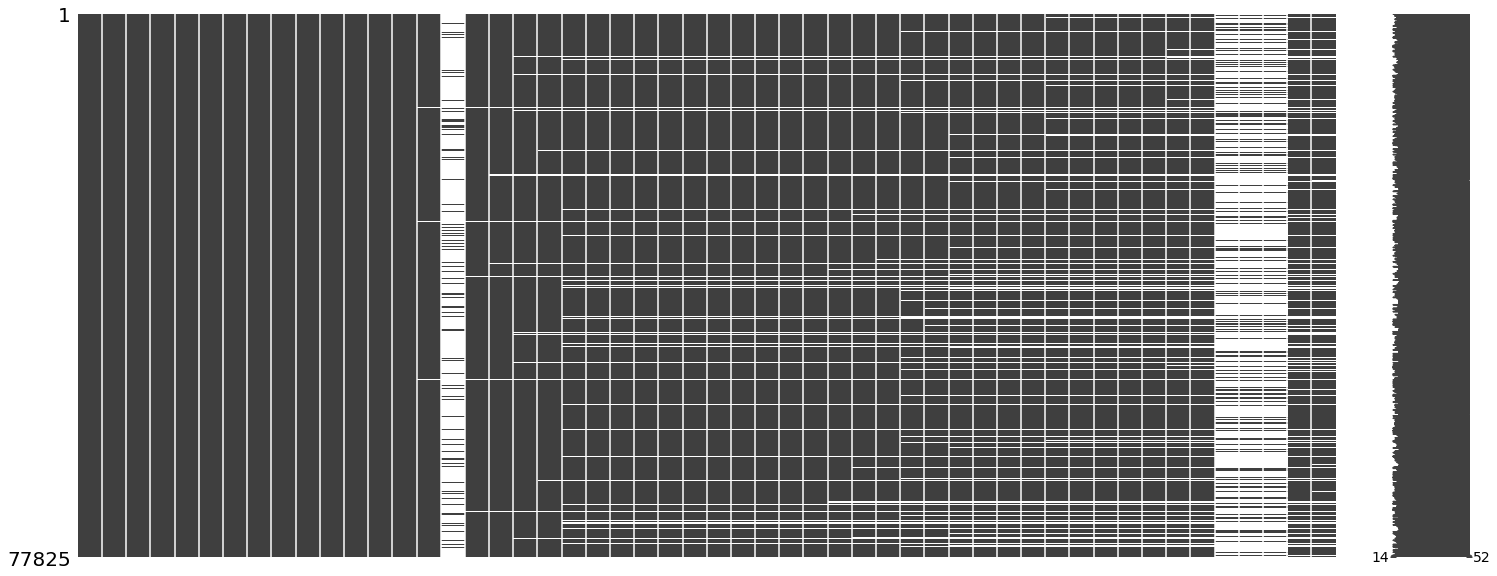

In [45]:
missingno.matrix(nan_viz)

Hmm, when I look at them in the order the questions were presented, I see that with the exception of a few columns that have a lot of nans, once missing answers start showing up, the rest of that record has missing answers.

**I suspect that the -88 Missing placeholder indicates that the respondent exited the questionnaire prematurely, and Census kept the incomplete answers in the sample.**

After re-reviewing the technical documentation, I found this paragraph buried towards the end:

>Responses are made up of complete interviews and sufficient partial interviews. A sufficient partial interview is an incomplete interview in which the household or person answered enough of the questionnaire to be considered a complete interview. Some remaining questions may have been edited or imputed to fill in missing values. Insufficient partial interviews are considered to be nonrespondents.

But there are a few columns that stand out as having a lot of -88 values and aren't following this pattern. I would like to look further into those before deciding how to proceed.

In [46]:
missing_sum = nan_viz.isna().sum(axis=0)
missing_sum.loc[q_order]

TBIRTH_YEAR          0
EGENDER              0
RHISPANIC            0
RRACE                0
EEDUC                0
MS                   0
THHLD_NUMKID         0
THHLD_NUMADLT        0
RECVDVACC            0
HADCOVID             0
WRKLOSS              0
EXPCTLOSS            0
ANYWORK              0
TW_START             0
UI_APPLY           197
UI_RECV          65991
SSA_RECV           519
SSA_APPLY          795
EIP               2212
EXPNS_DIF         2915
SPNDSRC1          7438
SPNDSRC2          7438
SPNDSRC3          7438
SPNDSRC4          7438
SPNDSRC5          7438
SPNDSRC6          7438
SPNDSRC7          7438
SPNDSRC8          7438
FEWRTRIPS         7438
FEWRTRANS         7438
PLNDTRIPS         7438
CURFOODSUF        7771
FREEFOOD          8032
SNAP_YN           8195
TSPNDFOOD        10775
TSPNDPRPD        11054
ANXIOUS          12614
WORRY            12614
INTEREST         12614
DOWN             12614
DELAY            13906
NOTGET           13906
PRESCRIPT        13906
MH_SVCS    

It looks like the four columns that don't fit the pattern are `UI_RECV`, `ENROLL1`, `ENROLL2`, and `ENROLL1`.

The data dictionary says that both of these questions were presented to everyone, but let me do some digging and see if perhaps the -88 count corresponds to the count of people who answered a certain way to a previous, related question.

In [47]:
df['UI_APPLY'].value_counts()

 0.0     65536
 1.0     11875
-99.0      217
-88.0      197
Name: UI_APPLY, dtype: int64

In [48]:
df['UI_RECV'].value_counts()

-88.0    65991
 1.0      9481
 2.0      2168
-99.0      185
Name: UI_RECV, dtype: int64

In [49]:
# What is the sum of people who answered No (0) or didn't answer 'UI_APPLY'?
print(65536 + 217 + 197)

65950


That's pretty darn close. I'm thinking 'UI_RECV' was only presented to people who said they actually applied for unemployment benefits.

In [50]:
# ENROLL1, ENROLL2, and ENROLL1 would only apply to households who said they
# had kids under 18
print(df['ENROLL1'].value_counts())
print(df['ENROLL2'].value_counts())
print(df['ENROLL3'].value_counts())

-88.0    57437
 1.0     14266
-99.0     6122
Name: ENROLL1, dtype: int64
-88.0    57437
-99.0    18627
 1.0      1761
Name: ENROLL2, dtype: int64
-88.0    57437
-99.0    15644
 1.0      4744
Name: ENROLL3, dtype: int64


In [51]:
df['THHLD_NUMKID'].value_counts()

0.0    52672
1.0    11499
2.0     8853
3.0     3195
4.0     1057
5.0      549
Name: THHLD_NUMKID, dtype: int64

There's some difference between the 52,672 people who said they didn't have kids in the household in question 8, and the 57,437 people who didn't answer the question about how their kids attended school in question 42. But it looks like a decent amount of people didn't make it that far in the questionnaire, so the ~5k differents could just be that.

## Strategy for Incomplete Questionnaires

I found the section of the technical documentation that says there are incomplete questionnaires, and the patterns I can see in the responses matches that. Now I need to decide whether to simply drop these incomplete answers and use only the complete ones, or account for them in some way.

To decide, I'll take a look at the class distribution for incomplete versus complete questionnaires and see if there appears to be a difference.

In [52]:
q_order.remove('ENROLL1')
q_order.remove('ENROLL2')
q_order.remove('ENROLL3')
q_order.remove('UI_RECV')

In [53]:
# populate incomplete column with sum of -88 values in top-level q columns
def sum_neg88(row):
    missing = row.isin([-88]).sum(axis=0)
    return missing

df['incomplete'] = df[all_preds].apply(sum_neg88, axis=1)

df['incomplete']

0        28
1         0
2        42
3         0
4         0
         ..
77820     0
77821     0
77822     0
77823     0
77824     0
Name: incomplete, Length: 77825, dtype: int64

In [54]:
print(list(df[all_preds].loc[2]))

[-88.0, 1.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, 6.0, 0.0, -88.0, 0.0, -88.0, -88.0, -88.0, -88.0, 1.0, 0.0, -88.0, -88.0, 0.0, -88.0, -88.0, -88.0, 1.0, -88.0, -88.0, -88.0, 0.0, 1.0, 0.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, 0.0, 0.0, -88.0, 1.0, 0.0, -88.0, 0.0, -88.0, 60.0, 2.0, 0.0, -88.0]


<AxesSubplot:xlabel='incomplete', ylabel='count'>

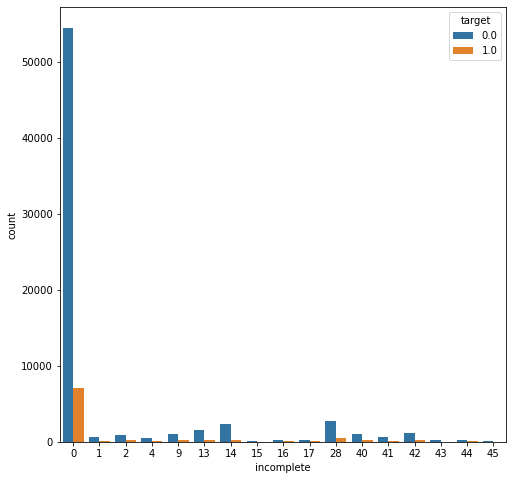

In [55]:
# plot number of incomplete questionnaires against target
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(x=df['incomplete'], hue=df['target'], ax=ax)

Too difficult to tell. I will bin the incompletes into 0, 1-17, and 28-45, then chart them as a stacked bar chart showing the total percentage.

In [56]:
# bin the incompletes based on the natural cutoff points shown above
df.loc[df['incomplete'] == 0, 'inc_bin'] = '0_None'
df.loc[(df['incomplete'] > 0) & (df['incomplete'] <= 17), 'inc_bin'] = '1_1 to 17'
df.loc[df['incomplete'] > 17, 'inc_bin'] = '2_Over 17'

df['inc_bin'].value_counts()

0_None       61514
1_1 to 17     8873
2_Over 17     7438
Name: inc_bin, dtype: int64

In [57]:
inc = df.groupby(['inc_bin', 'target'])['target'].count().unstack()
inc

target,0.0,1.0
inc_bin,,
0_None,54463,7051
1_1 to 17,7542,1331
2_Over 17,6315,1123


In [58]:
for row in inc.index:
    opt = inc.at[row, 0.0]
    hes = inc.at[row, 1.0]
    tot = opt + hes
    #print(opt, pes, tot)
    inc.loc[row, 'prop_opt'] = np.round(opt/tot, 2)
    inc.loc[row, 'prop_hes'] = np.round(hes/tot, 2)
    inc.loc[row, 'prop_tot'] = 1
    
inc 

target,0.0,1.0,prop_opt,prop_hes,prop_tot
inc_bin,,,,,
0_None,54463,7051,0.89,0.11,1.0
1_1 to 17,7542,1331,0.85,0.15,1.0
2_Over 17,6315,1123,0.85,0.15,1.0


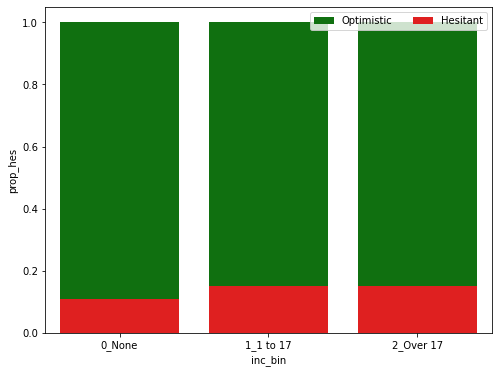

In [59]:
# https://www.tutorialspoint.com/how-to-create-a-stacked-bar-chart-for-my-dataframe-using-seaborn-in-matplotlib

fig, ax = plt.subplots(figsize=(8, 6))

opt = sns.barplot(x=inc.index, y='prop_tot', data=inc, label="Optimistic", color="green")
hes = sns.barplot(x=inc.index, y='prop_hes', data=inc, label="Hesitant", color="red")
plt.legend(ncol=2, loc="upper right", frameon=True)
plt.show()

Interesting, so it doesn't appear to make much difference how many incomplete questions were left (under 17 or over 17), in both cases the proportion of vaccine hesitants are 15%. This is compared to 11% vaccine hesitants in the population where people completed the whole thing.

I will create a binary column for 'incomplete' to use as a predictor, which will stand in for all the -88 values in the top-level questions. This should cut down on my cardinality a lot, although I'll still have the -99 values that represent someone skipping a particular question.

To make it easy to get rid of the -88 values I will set them equal to the 'first', or lowest value in the column, and when I use sklearn's OneHotEncoder, I will drop the first column.

I will convert -88 to -2 so it will be 'first' and will convert -99, which represents someone viewing but skipping a particular question, as -1.

In [60]:
# replace -88 with -2 and -99 with -1 for all cat cols
# I will still need to deal with some missing values in num cols

for col in cat_cols:
    df.loc[df[col] == -88, col] = -2
    df.loc[df[col] == -99, col] = -1

# check for remaining -88 and -99 values
print(list(df[cat_cols].isin([-88, -99]).sum(axis=0)))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [61]:
# take a look at which num cols have -88 or -99 values
df[num_cols].isin([-88, -99]).sum(axis=0)

PROP_FOODSPEND_HOME    14015
AGE                        0
THHLD_NUMADLT              0
THHLD_NUMKID               0
TNUM_PS                17177
dtype: int64

I will need to remember to do something else with these numerical values when I prepare the data for modeling, as they will need to be replaced with something. But for now, so I can chart the columns against the target, I will see if it's safe to assign -2 and -1 to my placeholders. I want to set them on a scale that will work well with the rest of the values when I chart them on a continuous x axis, but also be easy to single out for replacement with something else later.

In [67]:
# are there any values less than 0 other than -88 and -99?
df.loc[df['PROP_FOODSPEND_HOME'] < 0, ['PROP_FOODSPEND_HOME']].value_counts()

PROP_FOODSPEND_HOME
-88.0                  10775
-99.0                   3240
dtype: int64

In [68]:
# are there any values less than 0 other than -88 and -99?
df.loc[df['TNUM_PS'] < 0, ['TNUM_PS']].value_counts()

TNUM_PS
-88.0      15652
-99.0       1525
dtype: int64

In [69]:
# Both columns look fine t replace with -2 and -1
for col in ['TNUM_PS', 'PROP_FOODSPEND_HOME']:
    df.loc[df[col] == -88, col] = -2
    df.loc[df[col] == -99, col] = -1

# EXPLORE

In [ ]:
#class1 = df.loc[df['target']==1, ['target', 'EEDUC']]
#class0 = df.loc[df['target']==0, ['target', 'EEDUC']]
#sns.kdeplot(data=df, x='EEDUC', ax=ax, hue='target', common_norm=True, 
#            bw_adjust=2)

#multiple='dodge', shrink=0.75,
#,discrete=True, kde=True, kde_kws={}

#df['MS'] = df['MS'].astype('category',copy=False)

# this one worked, but not with categorical variables
#sns.displot(df, x='MS', hue="target", discrete=True, 
#            multiple='dodge', shrink=0.75, kde=True, 
#            kde_kws={'bw_adjust':3})

<ipython-input-71-b9b54bf74269>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 8))


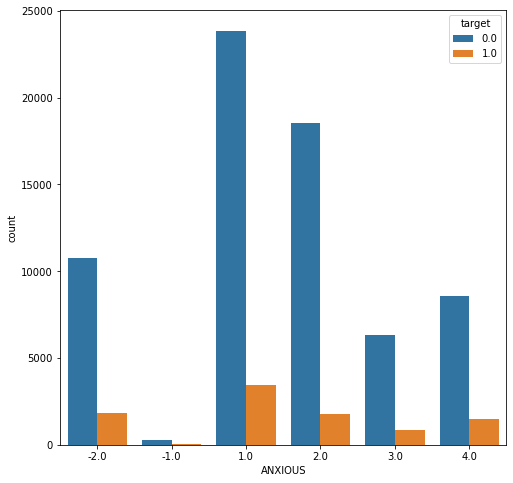

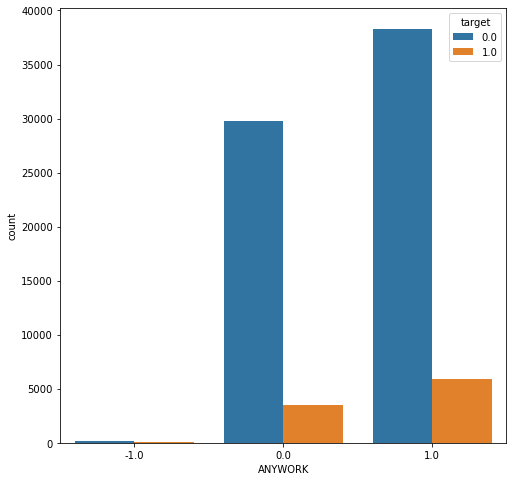

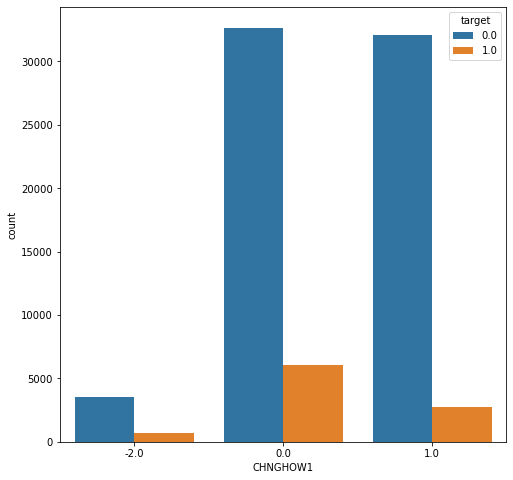

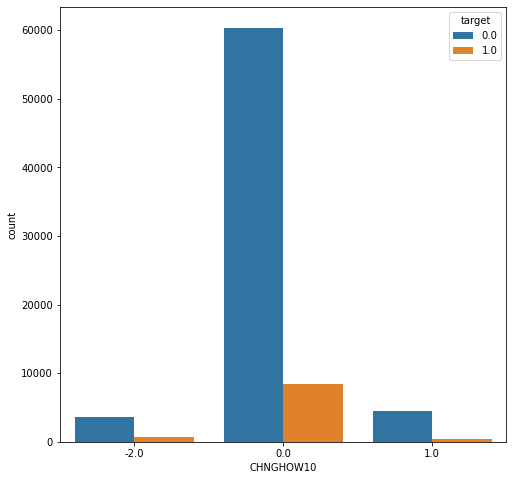

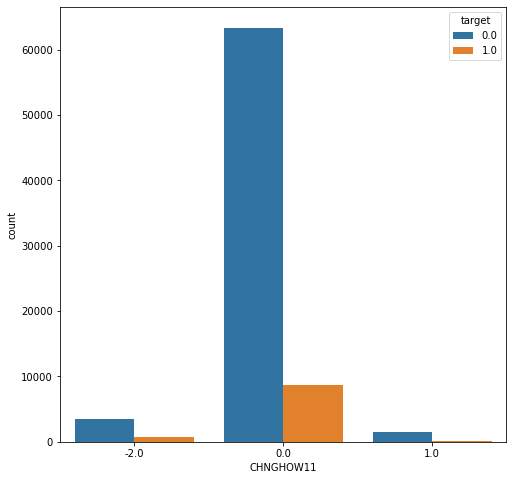

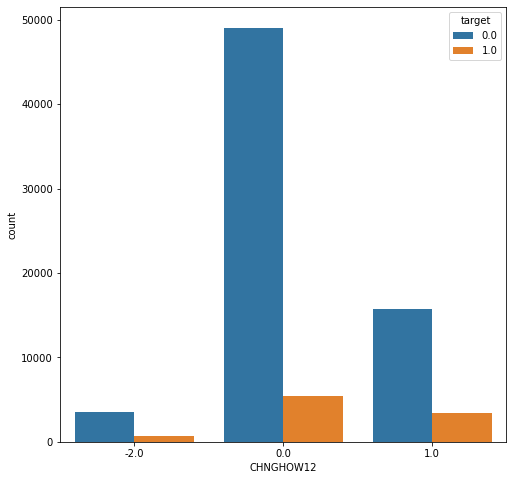

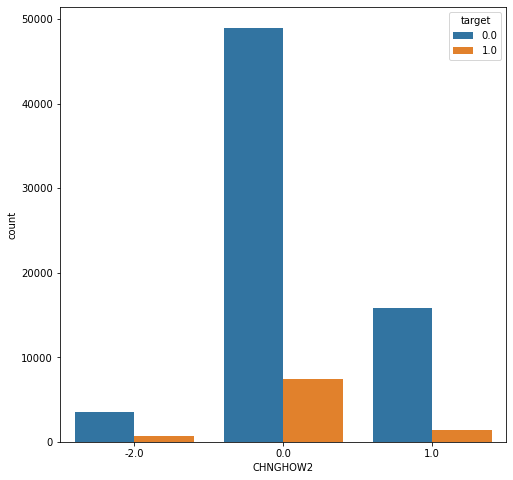

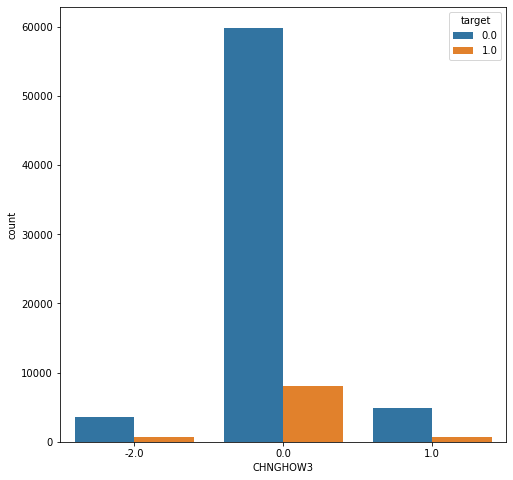

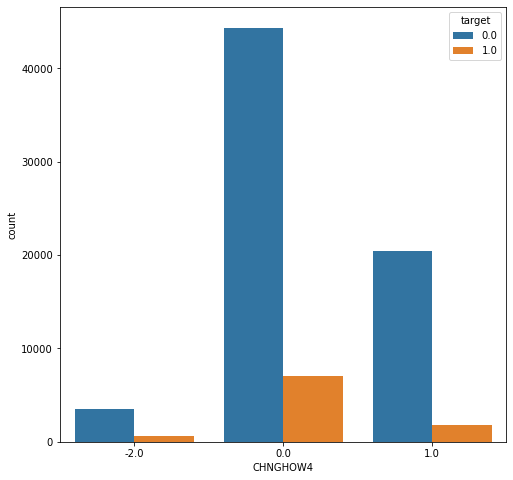

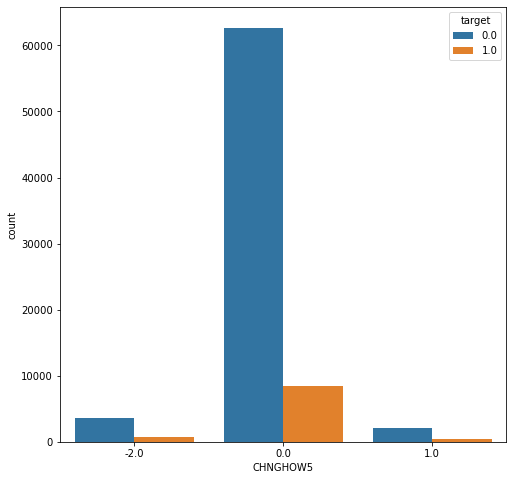

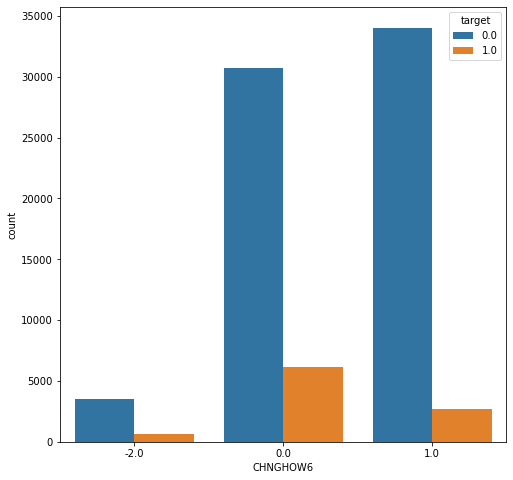

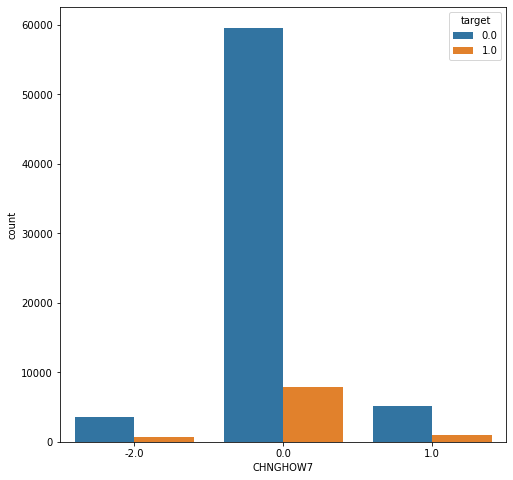

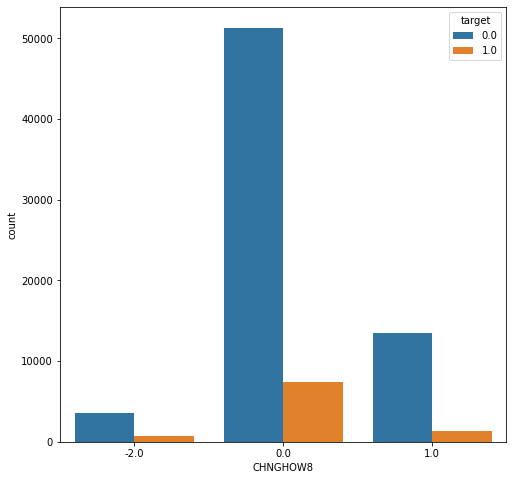

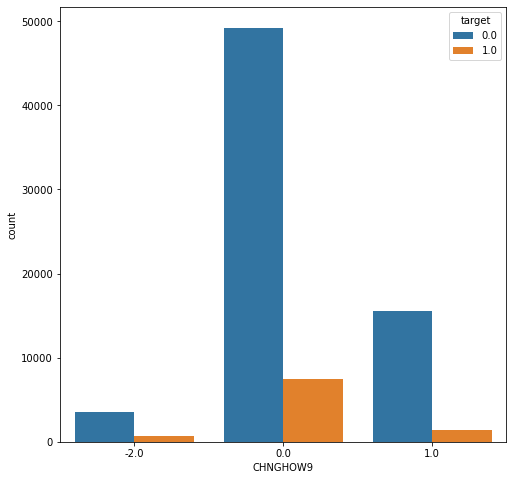

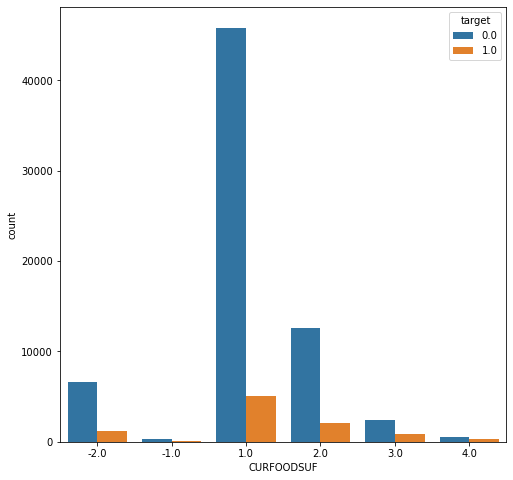

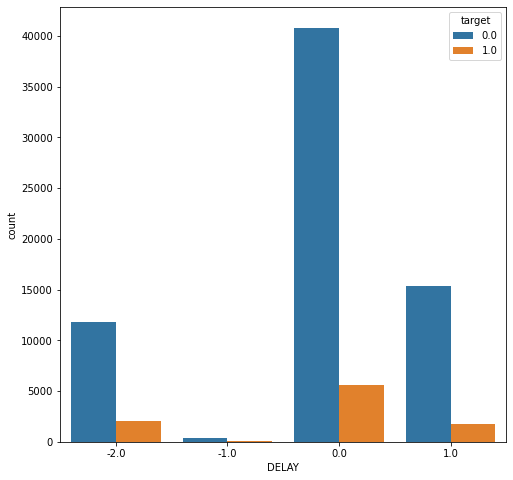

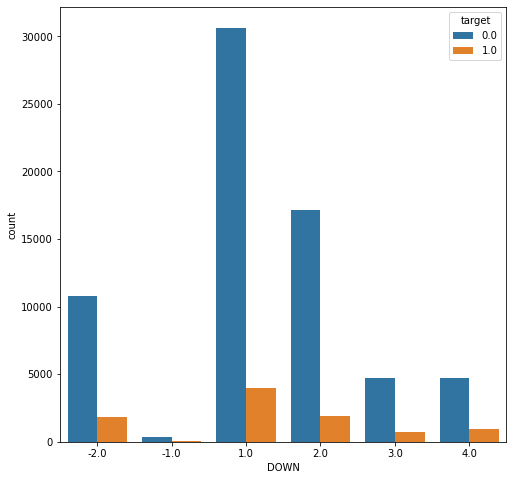

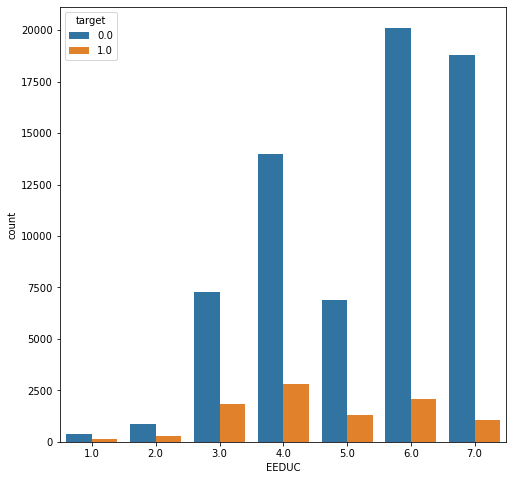

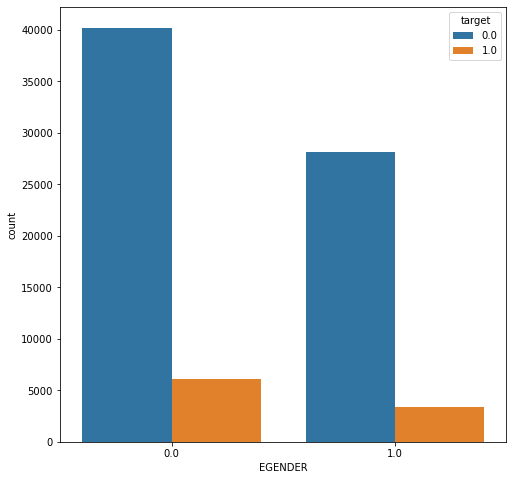

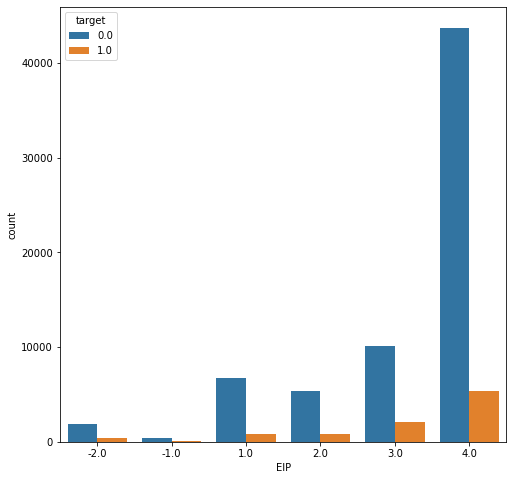

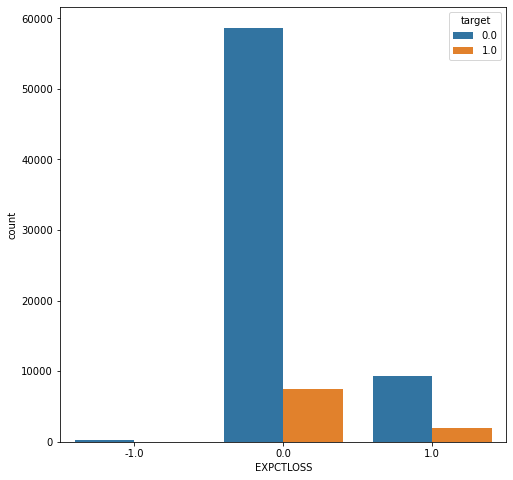

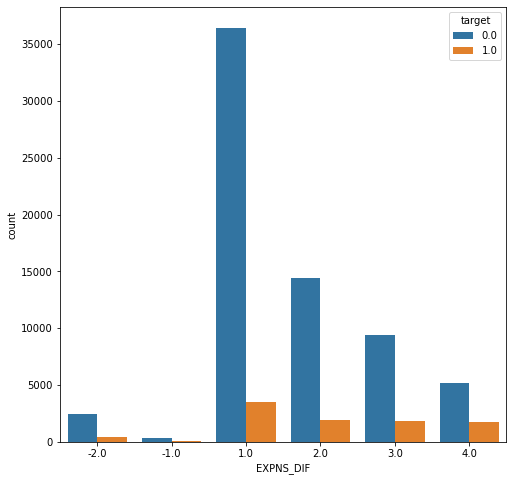

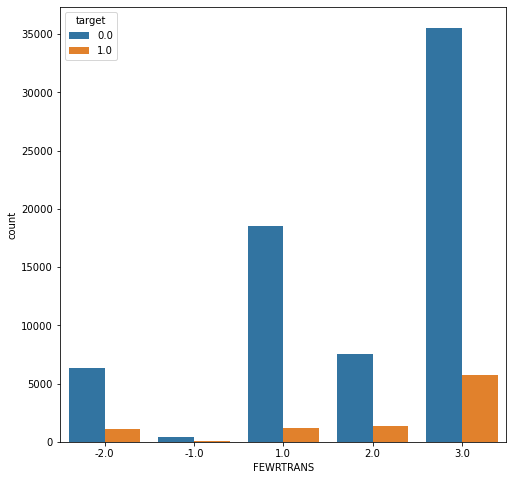

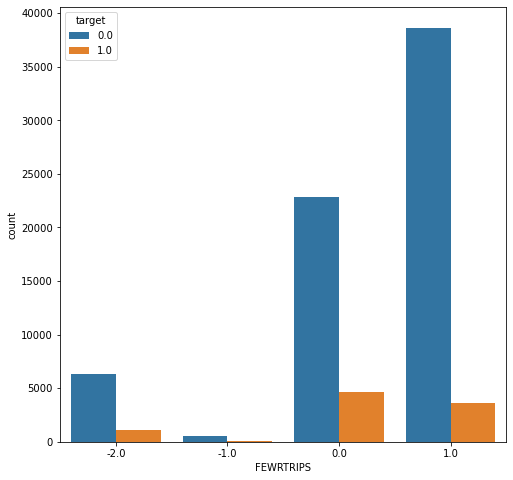

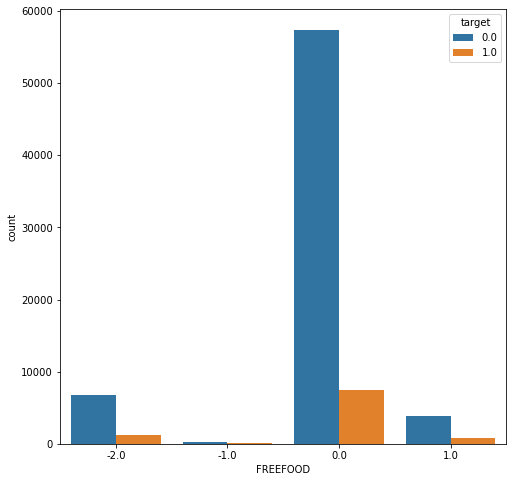

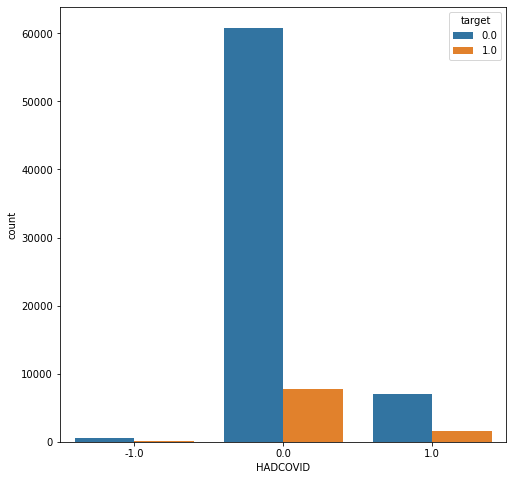

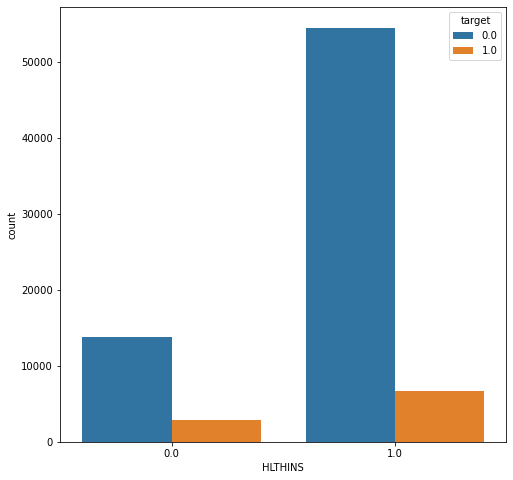

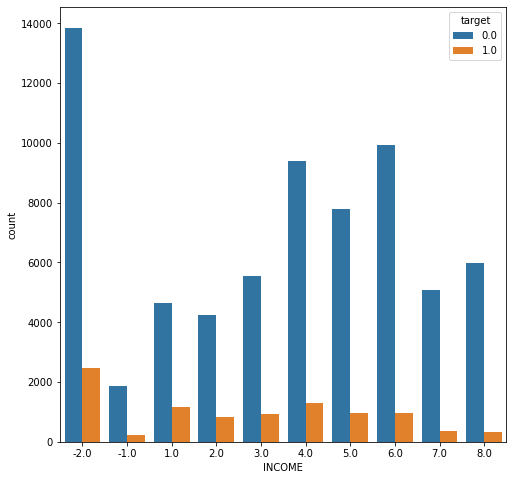

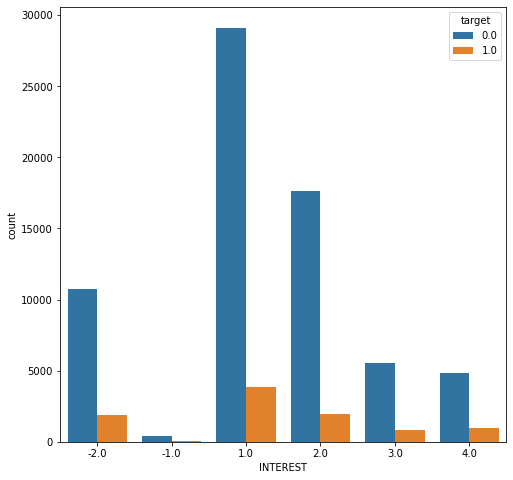

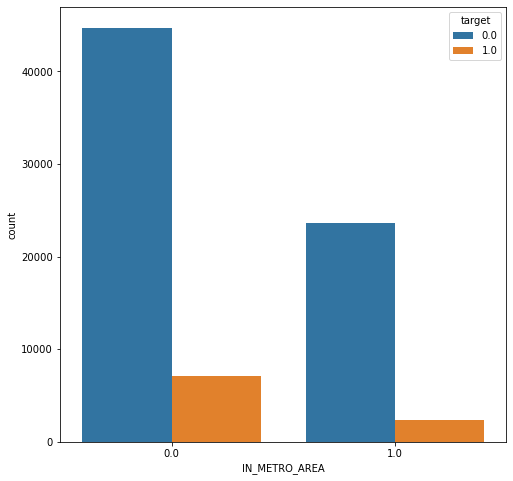

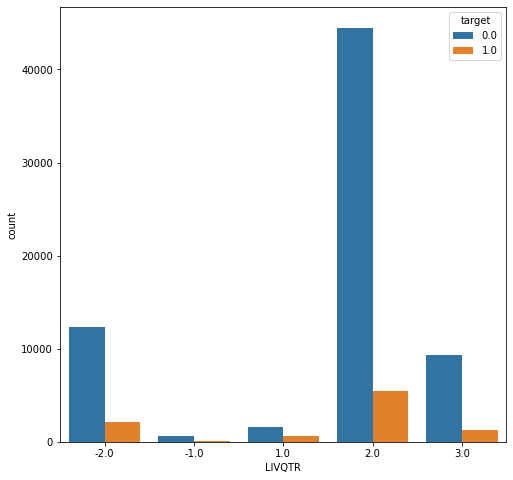

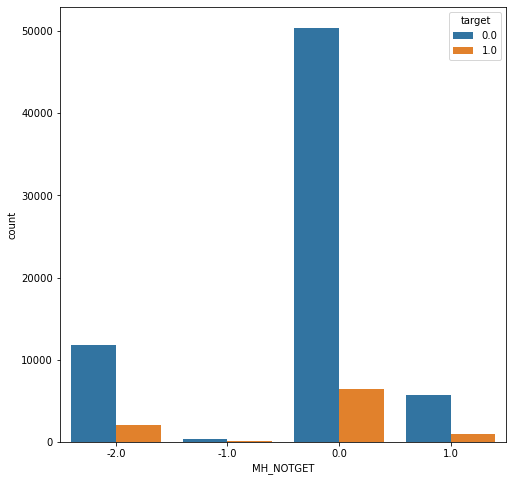

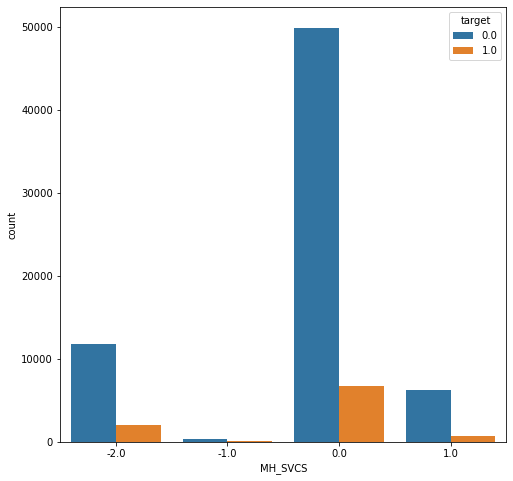

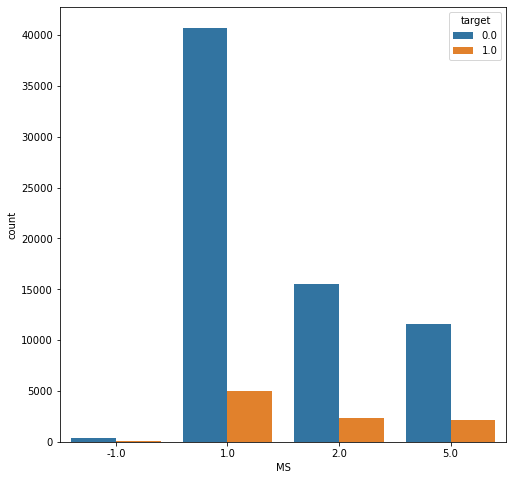

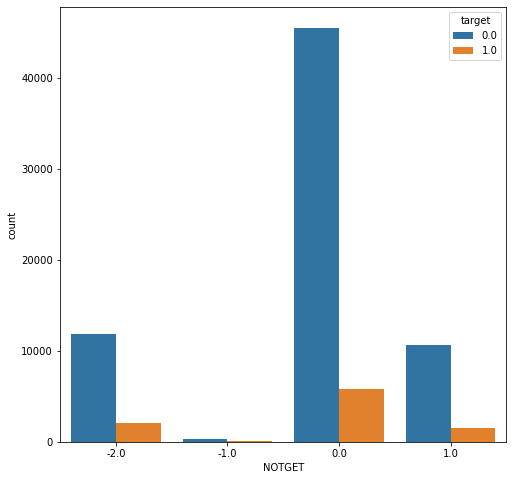

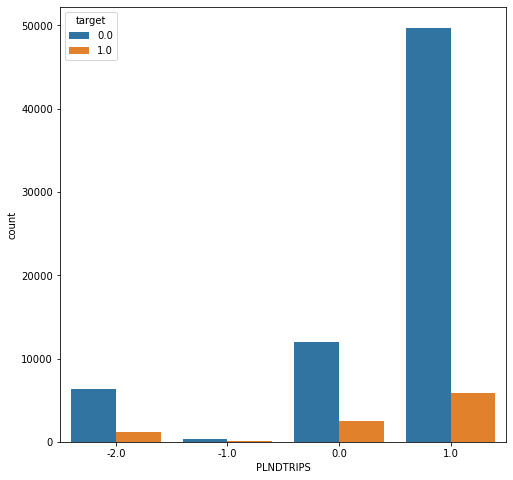

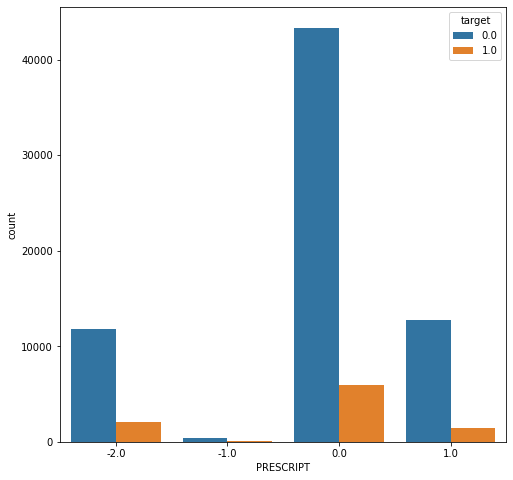

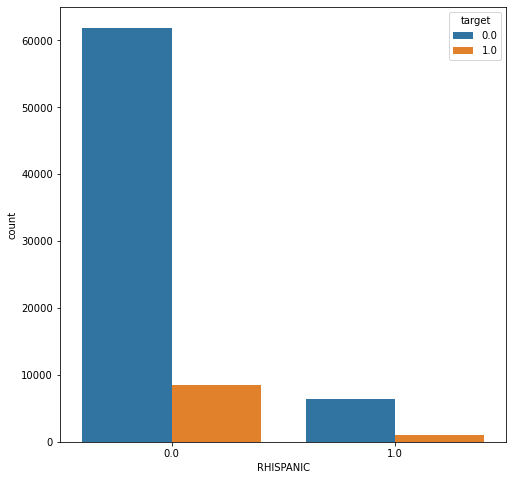

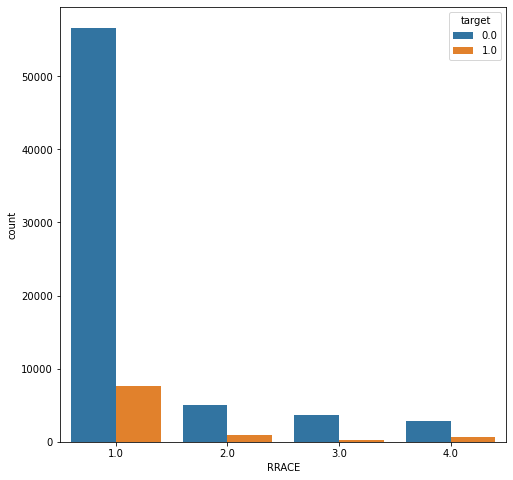

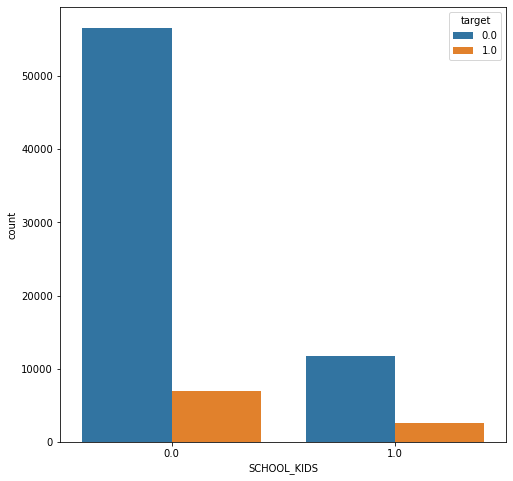

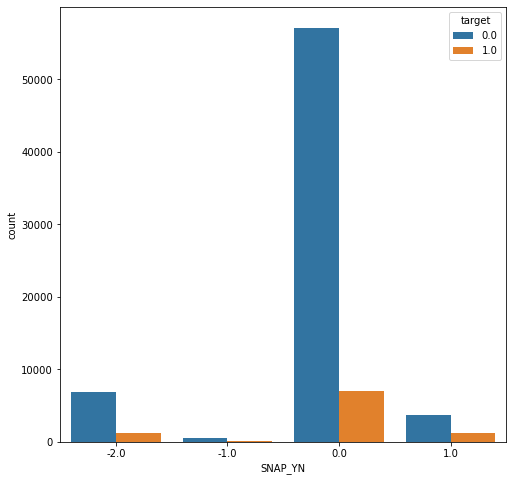

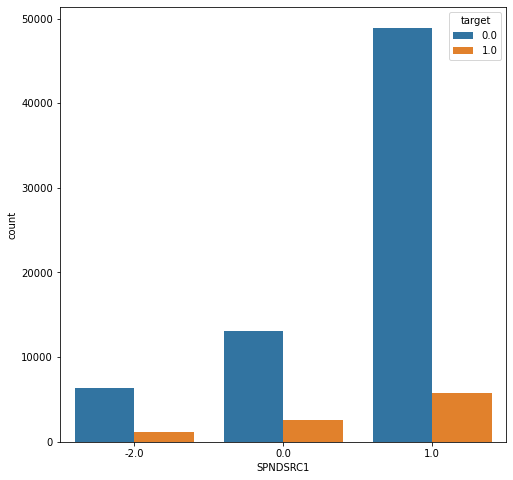

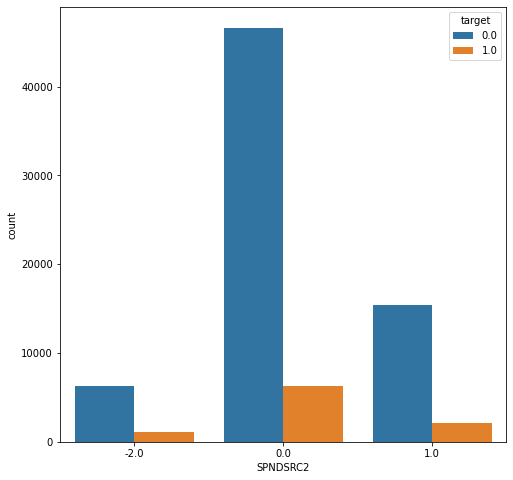

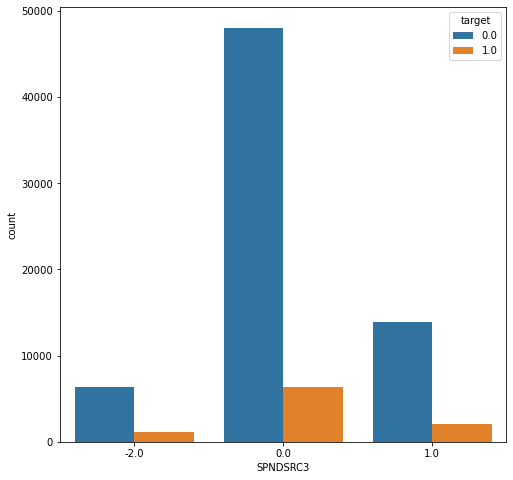

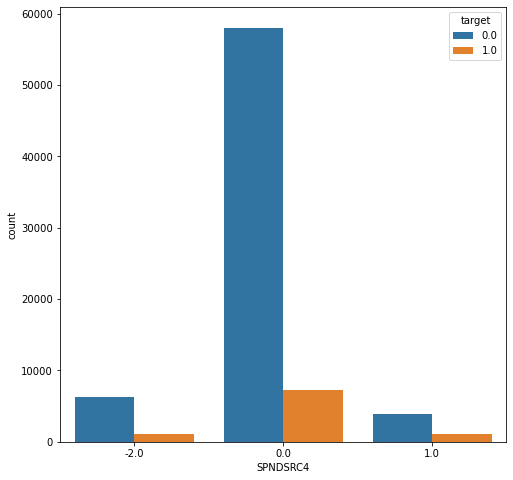

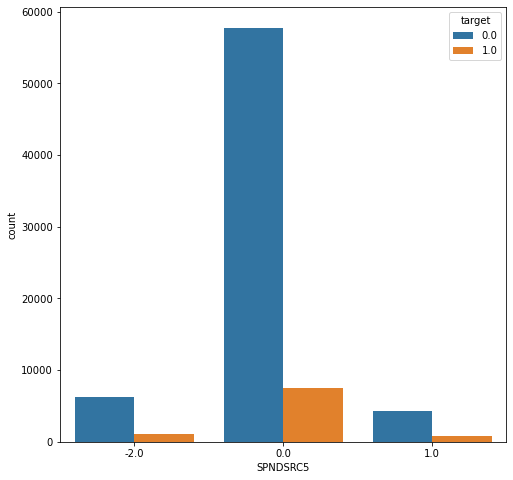

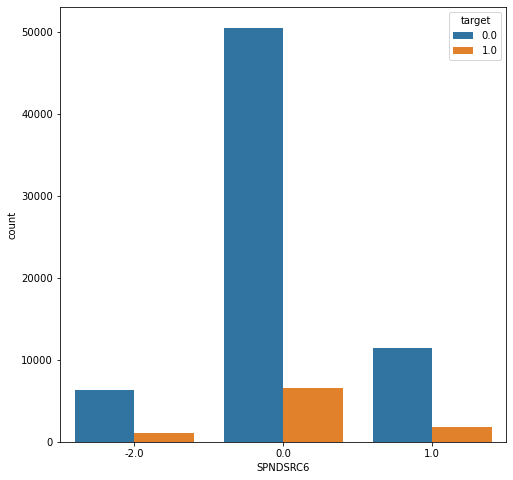

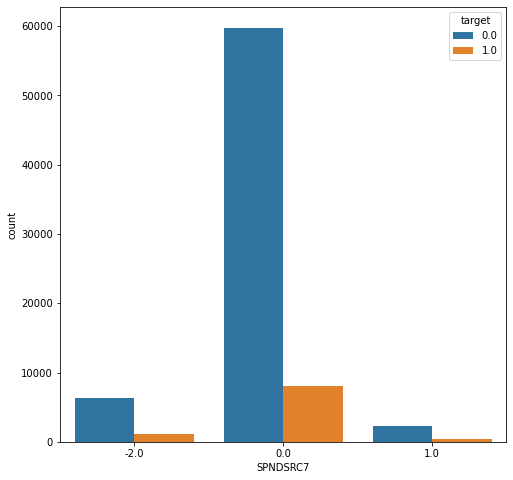

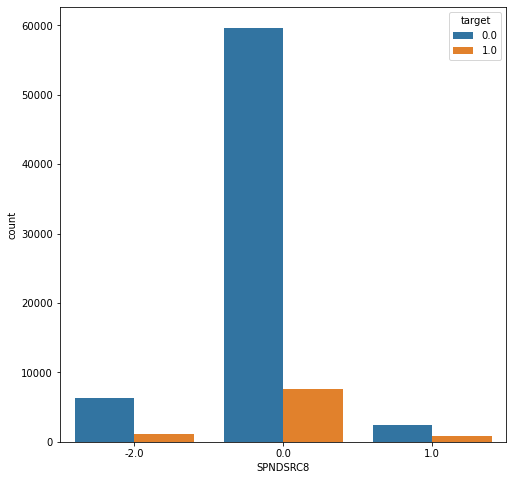

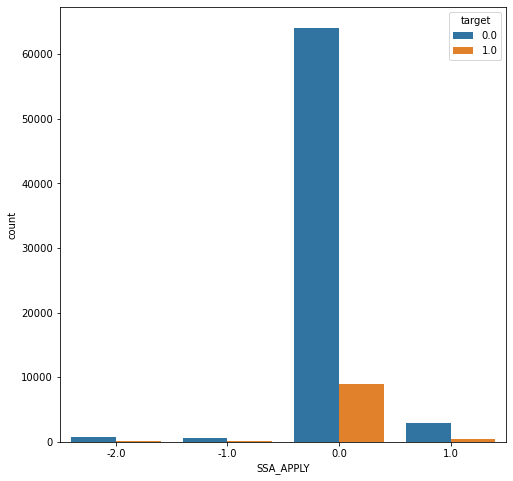

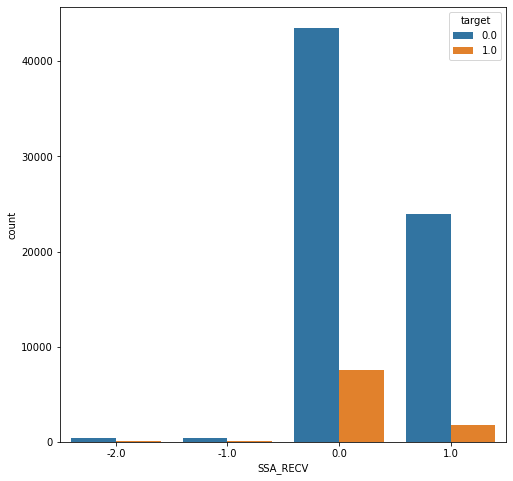

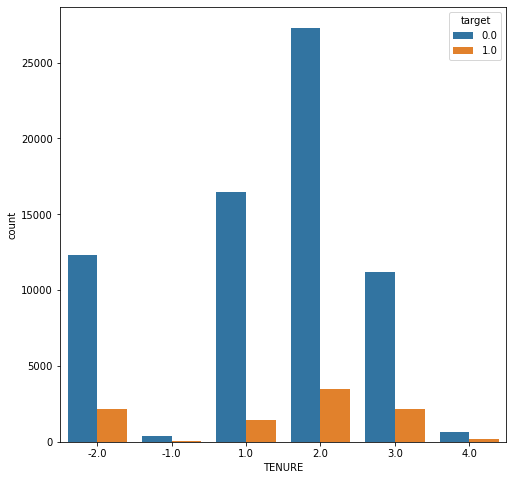

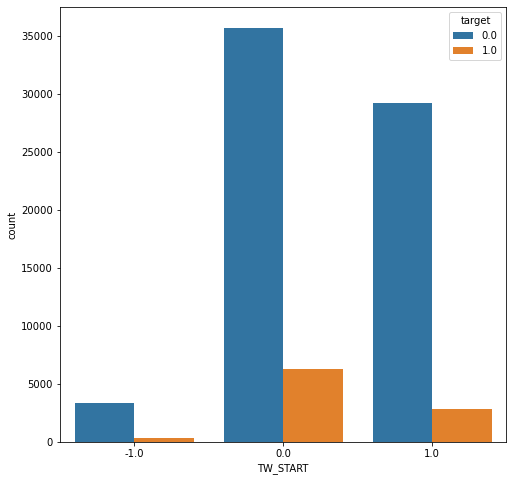

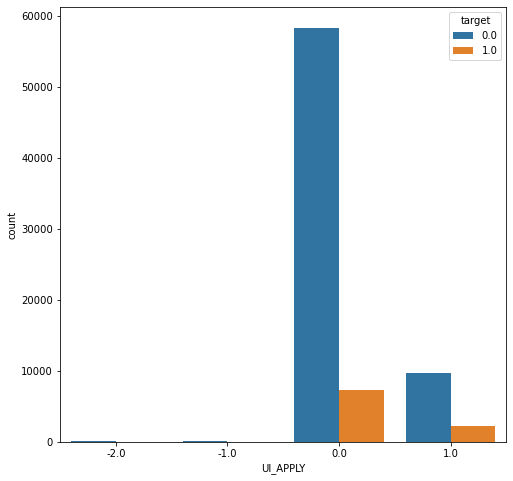

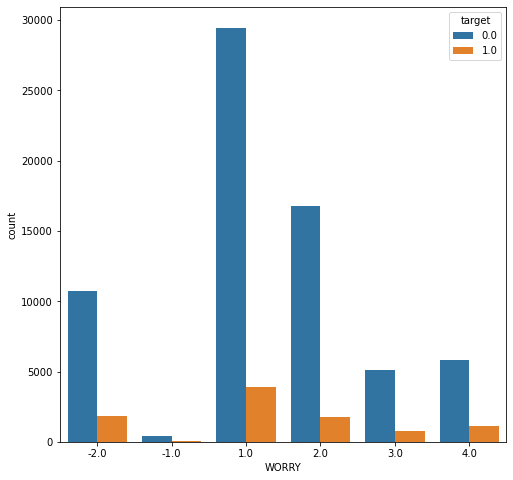

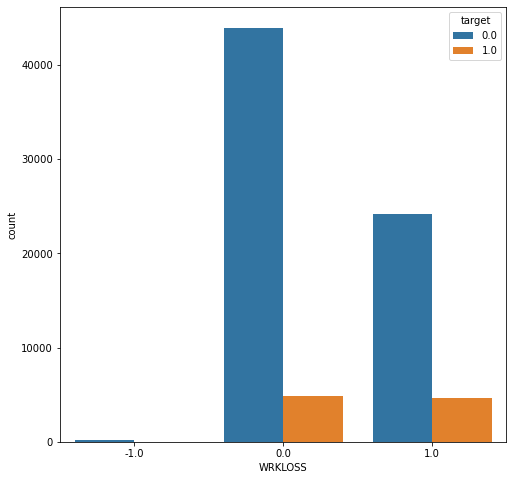

In [71]:
# plot class distribution for each cat col and per target class
for col in cat_cols:
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.countplot(data=df, x=col, hue="target", ax=ax)

# MODEL

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

# iNTERPRET

Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

# CONCLUSIONS & RECOMMENDATIONS

Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***